In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load the dataset
df = pd.read_excel('timeseries.xlsx')

# Perform Augmented Dickey-Fuller test
result = adfuller(df['X3'])

# Output the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[0] < result[4]['5%']:
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Failed to reject the null hypothesis - Data is non-stationary")


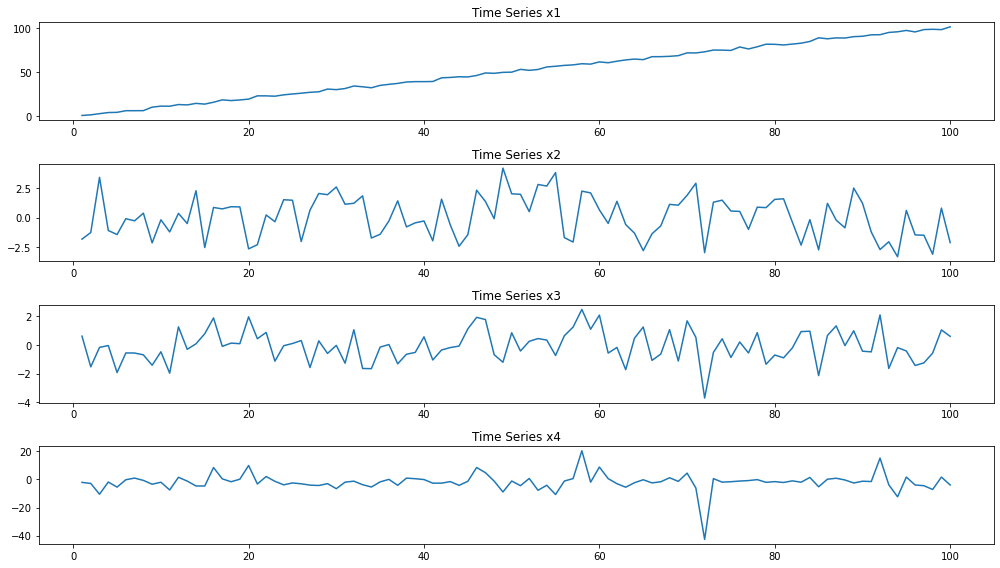

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
N = 100  # Length of the time series
alpha = 1.0  # Value of alpha
beta = 0.5  # Value of beta
noise_std = 1.0  # Standard deviation of noise

# Time vector
t = np.linspace(1, N, N)

# Piecewise function β(t)
beta_t = np.where(t <= N / 2, 0, beta)

# Function z(t) = αt + β(t)
z_t = alpha * t + beta_t

# Noise terms
e1 = np.random.normal(0, noise_std, N)
e2 = np.random.normal(0, noise_std, N)
e3 = np.random.normal(0, noise_std, N)
e4 = np.random.normal(0, noise_std, N)

# Equations for x1, x2, x3, x4
x1 = z_t + e1
x2 = -2 * np.sin(2 * x1) + e2
x3 = np.exp(-x1) * x2 + e3
x4 = x3**3 - x2**2 * np.cos(x3) + e4

# Plot the time series
plt.figure(figsize=(14, 8))
plt.subplot(4, 1, 1)
plt.plot(t, x1)
plt.title('Time Series x1')

plt.subplot(4, 1, 2)
plt.plot(t, x2)
plt.title('Time Series x2')

plt.subplot(4, 1, 3)
plt.plot(t, x3)
plt.title('Time Series x3')

plt.subplot(4, 1, 4)
plt.plot(t, x4)
plt.title('Time Series x4')

plt.tight_layout()
plt.show()


In [7]:
data = pd.DataFrame({
    'X1': x1,
    'X2': x2,
    'X3': x3,
    'Y1': x4
})


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
# Assuming Autoformer implementation is available as AutoformerModel

# Load your data

# Preprocess your data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['X1', 'X2', 'X3']].values)
scaled_target = scaler.fit_transform(data[['Y1']].values.reshape(-1, 1))

# Split your data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
train_features = torch.Tensor(X_train)
test_features = torch.Tensor(X_test)
train_targets = torch.Tensor(y_train)
test_targets = torch.Tensor(y_test)

# Create DataLoader instances
train_dataset = TensorDataset(train_features, train_targets)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(test_features, test_targets)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the Autoformer model
#model = AutoformerModel(input_size=3, output_size=1, ...) # Adjust parameters as necessary

# Train the model
# This is a simplified example. You'll need to define an optimizer, loss function, and possibly a learning rate scheduler.
# You'll also need to iterate over epochs, compute the loss, and update the model's weights.

# Forecasting
# Use the trained model to predict on your test set or future unseen data


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from layers.Embed import DataEmbedding, DataEmbedding_wo_pos
from layers.AutoCorrelation import AutoCorrelation, AutoCorrelationLayer
from layers.Autoformer_EncDec import Encoder, Decoder, EncoderLayer, DecoderLayer, my_Layernorm, series_decomp
import math
import numpy as np


class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention

        # Decomp
        kernel_size = configs.moving_avg
        self.decomp = series_decomp(kernel_size)

        # Embedding
        # The series-wise connection inherently contains the sequential information.
        # Thus, we can discard the position embedding of transformers.
        self.enc_embedding = DataEmbedding_wo_pos(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                                  configs.dropout)
        self.dec_embedding = DataEmbedding_wo_pos(configs.dec_in, configs.d_model, configs.embed, configs.freq,
                                                  configs.dropout)

        # Encoder
        self.encoder = Encoder(
            [EncoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(False, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=configs.output_attention),configs.d_model,
                                        configs.n_heads), configs.d_model, configs.d_ff, moving_avg=configs.moving_avg, 
                                        dropout=configs.dropout, activation=configs.activation) for l in range(configs.e_layers)],
                                        norm_layer=my_Layernorm(configs.d_model))
        # Decoder
        self.decoder = Decoder(
            [DecoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(True, configs.factor, attention_dropout=configs.dropout, output_attention=False),
                                        configs.d_model,configs.n_heads),
                    AutoCorrelationLayer(
                        AutoCorrelation(False, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=False),
                                        configs.d_model, configs.n_heads),configs.d_model,
                                        configs.c_out,configs.d_ff,moving_avg=configs.moving_avg,
                                        dropout=configs.dropout, activation=configs.activation,)
                for l in range(configs.d_layers)
            ],
            norm_layer=my_Layernorm(configs.d_model),
            projection=nn.Linear(configs.d_model, configs.c_out, bias=True))

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        # decomp init
        mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.pred_len, 1)
        zeros = torch.zeros([x_dec.shape[0], self.pred_len, x_dec.shape[2]], device=x_enc.device)
        seasonal_init, trend_init = self.decomp(x_enc)
        # decoder input
        trend_init = torch.cat([trend_init[:, -self.label_len:, :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.label_len:, :], zeros], dim=1)
        # enc
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)
        # dec
        dec_out = self.dec_embedding(seasonal_init, x_mark_dec)
        seasonal_part, trend_part = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask,
                                                 trend=trend_init)
        # final
        dec_out = trend_part + seasonal_part

        if self.output_attention:
            return dec_out[:, -self.pred_len:, :], attns
        else:
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]

ModuleNotFoundError: No module named 'layers'

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess your data
# Assuming 'data' is loaded as shown previously

# Define your configs object with appropriate values
configs = {
    'seq_len': 24,  # Example values
    'label_len': 48,
    'pred_len': 24,
    'output_attention': False,
    'enc_in': 3,  # Number of input features
    'dec_in': 3,
    'c_out': 1,  # Number of output features
    'd_model': 512,
    'n_heads': 8,
    'e_layers': 3,
    'd_layers': 3,
    'd_ff': 2048,
    'dropout': 0.05,
    'moving_avg': 25,
    'factor': 5,
    'activation': 'gelu',
    'embed': 'fixed',  # Example: fixed or learnable embedding
    'freq': 'h',  # Frequency of your data, example: 'h' for hourly
}

# Convert configs dictionary to an object for easier attribute access
class ConfigObject(object):
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

configs = ConfigObject(configs)

# Instantiate the model
model = Model(configs)

# Assume 'train_loader' and 'test_loader' are DataLoader instances prepared from your dataset
# Define your training loop, loss function, optimizer, etc.

# Example simplified training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for epoch in range(num_epochs):
    model.train()
    for x_enc, x_mark_enc, x_dec, x_mark_dec, y in train_loader:
        optimizer.zero_grad()
        output = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    
    # Validation step
    # Note: Make sure to track and validate your model's performance on a separate validation set or with cross-validation

# Forecasting
# Use the trained model for forecasting on new data


NameError: name 'Model' is not defined